In [19]:
import curses
import time
import sys
from random import randint
import numpy as np
import time
from tqdm import tqdm
import os
from collections import deque
import time
import random
from random import randint
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as img
import csv
import numpy as np
from tensorflow.keras.models import Sequential,load_model

from tensorflow.keras.layers import Dense, Dropout, Conv2D,Conv1D, MaxPooling2D,MaxPooling1D, Activation, Flatten,AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

import tensorflow.python.keras.backend as backend
from collections import deque
from random import randint
from PIL import Image

Init Plugin
Init Graph Optimizer
Init Kernel


In [20]:
DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 10000  
MIN_REPLAY_MEMORY_SIZE = 1000 
MINIBATCH_SIZE = 128  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)
MODEL_NAME = 'snake'
MIN_REWARD = -200  # For model save
MEMORY_FRACTION = 0.20
LEARNING_RATE = 0.0001

# Environment settings
EPISODES = 500
ENV_SIZE = 10

# Exploration settings
EPSILON_DECAY = 0.99
MIN_EPSILON = 0.0

#  Stats settings
AGGREGATE_STATS_EVERY = 10  # episodes
SHOW_PREVIEW = True

In [21]:
class Field:
    #Initialize game field
    def __init__(self,size):
        self.size = size
        self.icons = {
            0: ' . ',
            1: ' * ',
            2: ' # ',
            3: ' & ',
            4 : ' 0 '
        }
        self.d = {
            0: (255, 255, 255),
            1: (0, 255, 170),
            2: (0,255,0),
            3: (0, 0, 255),
            4: (0,0,0)
            }
        self.snake_coords = [[5, 4], [5, 5]]
        self._generate_field()
        self.add_entity()
        if self.get_entity_pos()==[-1,-1]:
            self.add_entity()

    def reset(self):
        #self.snake_coords = []
        self._generate_field()
        self.add_entity()
        self.snake_coords = [[5, 4], [5, 5]]
        if self.get_entity_pos()==[-1,-1]:
            self.add_entity()

    #Add food to field
    def add_entity(self):
        
        while(True):
            i = randint(2, self.size-2)
            j = randint(2, self.size-2)
            entity = [i, j]
            
            if entity not in self.snake_coords:
                self.field[i][j] = 3
                break

    #Generate field 
    def _generate_field(self):
        self.field = np.zeros((self.size, self.size), dtype=np.uint8) 
    
    #Clear field
    def _clear_field(self):        
        self.field = [[j if j!= 1 and j!= 2 else 0 for j in i] for i in self.field]

    #Add all chars to screen
    def render(self, show):
        size = self.size
        self._clear_field()

        # Render snake on the field
        for i, j in self.snake_coords:
            self.field[i][j] = 1
        if self.get_entity_pos()==[-1,-1]:
            self.add_entity()

        # Mark head
        head = self.snake_coords[len(self.snake_coords)-1]
        self.field[head[0]][head[1]] = 2

        for i in range(self.size):
                self.field[i][0] = 4
                self.field[0][i] = 4
                self.field[self.size-1][i] = 4
                self.field[i][self.size-1] = 4

        if show:
            for i in range(self.size):
                row = ''
                for j in range(self.size):
                    row += self.icons[ self.field[i][j] ]
                    #screen.addstr(i, 0, row)
                print(row,'\n')
            #colour = self.get_image(self.field)
            #newImage = Image.fromarray(colour, 'RGB')
            #img.imsave('scaled.png', colour);
                
        return np.array(self.field)
    
    def get_image(self,game_field):
        env = np.zeros((self.size, self.size, 3), dtype=np.uint8)  # starts an rbg of our size
        for i in range(self.size):
            for j in range(self.size):
                if game_field[i][j]==0:
                    env[i][j] = self.d[0]
                if game_field[i][j]==1:
                        env[i][j] = self.d[1]
                if game_field[i][j]==2:
                        env[i][j] = self.d[2]
                if game_field[i][j]==3:
                        env[i][j] = self.d[3]

                  # sets the player tile to blue
        img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
        return img

    def get_entity_pos(self):
        for i in range(self.size):
            for j in range(self.size):
                if self.field[i][j] == 3:
                    return [i, j]

        return [-1, -1]


    def is_snake_eat_entity(self):
        entity = self.get_entity_pos()
        head = self.snake_coords[-1]

        return entity == head


In [22]:
class Snake:
    def __init__(self):
        self.direction = 0

        # Init basic coords
        self.coords = [[5, 4], [5, 5]]

    def reset(self):
        self.direction = 0

        # Init basic coords
        self.coords = [[5, 4], [5, 5]]
        
    def set_direction_normal(self, ch):

        # Check if wrong direction
        if ch == 1 and self.direction == 0:
            return
        if ch == 0 and self.direction == 1:
            return
        if ch == 3 and self.direction == 2:
            return
        if ch == 2 and self.direction == 3:
            return 

        self.direction = ch

    def set_direction_random(self):
        rand_dir = randint(0, 4)
        # Check if wrong direction
        if rand_dir == 0 and  self.direction != 0:
            self.direction = 1
        if rand_dir == 1 and  self.direction != 1:
            self.direction = 0
        if rand_dir == 2 and self.direction != 2:
            self.direction = 2
        if rand_dir == 3 and self.direction != 3:
            self.direction = 3



    def level_up(self):
        # get last point direction
        a = self.coords[0]
        b = self.coords[1]

        tail = a[:]

        if a[0] < b[0]:
            tail[0]-=1
        elif a[1] < b[1]:
            tail[1]-=1
        elif a[0] > b[0]:
            tail[0]+=1
        elif a[1] > b[1]:
            tail[1]+=1

        tail = self._check_limit(tail)
        self.coords.insert(0, tail)

    def is_dead(self):
        head = self.coords[-1]
        snake_body = self.coords[:-1]

        return head in snake_body

    def hit_wall(self):
        head = self.coords[-1]
        self.walls = []
        for i in range(self.field.size):
            self.walls.append([i,0])
            self.walls.append([0,i])
            self.walls.append([self.field.size-1,i])
            self.walls.append([i,self.field.size-1])

        return head in self.walls


    def _check_limit(self, point):
        # Check field limit
        if point[0] > self.field.size-1:
            point[0] = 0
        elif point[0] < 0:
            point[0] = self.field.size-1
        elif point[1] < 0:
            point[1] = self.field.size-1
        elif point[1] > self.field.size-1:
            point[1] = 0

        return point

    def move(self):
        # Determine head coords
        head = self.coords[-1][:]
        done=False
        # Calc new head coords
        if self.direction == 3:
            head[0]-=1
        elif self.direction == 2:
            head[0]+=1
        elif self.direction == 0:
            head[1]+=1
        elif self.direction == 1:
            head[1]-=1
        reward = -0.01
        # Check field limit
        head = self._check_limit(head)

        del(self.coords[0])
        self.coords.append(head)
        self.field.snake_coords = self.coords

        if  self.is_dead():
            reward = -5
            done = True

        if self.hit_wall():
            reward = -5
            done =True


        # check if snake eat an entity
        if self.field.is_snake_eat_entity():
            #curses.beep()
            self.level_up()
            self.field.add_entity()
            reward = 1
        return done,reward


    def set_field(self, field):
        self.field = field

In [23]:

LOAD_MODEL = None

#LOAD_MODEL = 'models/snake____-6.38max__-10.60avg__-15.51min__1631201844.model'

class Agent:
    def __init__(self,game_type):

        # Main model
        self.load = None
        self.gt = game_type
        self.model = self.create_model()

        # Target network
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        # An array with last n steps for training
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        
        
        # Custom tensorboard object
        #self.tensorboard = ModifiedTensorBoard(log_dir="logs/{}-{}".format(MODEL_NAME, int(time.time())))

        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0

    def create_model(self):
        model = Sequential()
        if self.gt == '2':
            self.load = 'models/snake_____9.71max____5.18avg___-6.99min__1634638748.model'
            print(f'Model Loading')
            model = load_model(self.load)
            print(f'Model Loaded')
   
        else:
            model = Sequential()

            model.add(Conv2D(64,(3, 3),activation='relu', input_shape=(ENV_SIZE,ENV_SIZE,1)))  # OBSERVATION_SPACE_VALUES = (10, 10, 3) a 10x10 RGB image.
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(0.2))
            model.add(Conv2D(64, (3, 3), activation='relu'))
            model.add(MaxPooling2D((2, 2)))

            model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
            model.add(Dense(64,activation='relu'))
            model.add(Dense(64,activation='relu'))
            model.add(Dense(64,activation='relu'))
            model.add(Dense(4, activation='softmax'))  # ACTION_SPACE_SIZE = how many choices (4)
            model.compile(loss='mse', optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])
        return model


    # Adds step's data to a memory replay array
    # (observation space, action, reward, new observation space, done)
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    # Trains main network every step during episode
    def train(self, terminal_state, step):

        # Start training only if certain number of samples is already saved
        if len(self.replay_memory) < MINIBATCH_SIZE:
            return

        # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/4
        current_qs_list = self.model.predict(current_states)

        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3] for transition in minibatch])/4
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
                #new_q = current_qs_list[index][action]*(1-LEARNING_RATE)+(LEARNING_RATE)*(reward + DISCOUNT * max_future_q)
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state
        self.model.fit(np.array(X)/4, np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False)

        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

    # Queries main network for Q values given current observation space (environment state)
    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/4)[0]

In [24]:
def main():
    # Configure screen
    #screen.timeout(0)
    ep_rewards = []
    ep_score = []
    avgs = []
    steps = []
    max_rewards = []
    epsilon = 0.5
    
    # For more repetitive results
    random.seed(1)
    np.random.seed(1)
    tf.random.set_seed(1)

    if not os.path.isdir('models'):
        os.makedirs('models')
    if not os.path.isdir('images'):
        os.makedirs('images')
    if not os.path.isdir('testing'):
        os.makedirs('testing')
        
    field = Field(ENV_SIZE)
    snake = Snake()
    game_type = input("Enter 1 training the model for or 2 for agent playing ")
    agent = Agent(game_type)

    #Train a new agent
    if game_type == '1':
        for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):
        

        # Update tensorboard step every episode
        #agent.tensorboard.step = episode

        # Restarting episode - reset episode reward and step number
            episode_reward = 0
            score = 0
            step = 1
            new_step = 0
            average_reward = -11
            old_avg = -11
            # Reset environment and get initial state

            field.reset()
            snake.reset()
            current_field = field.render(False)
            current_state = field.get_image(current_field)

            # Reset flag and start iterating until episode ends
            done = False
            action = 0
            while not done:

                # This part stays mostly the same, the change is to query a model for Q values
                if np.random.random() > epsilon:
                    # Get action from Q table
                    action = np.argmax(agent.get_qs(current_field))
                    #print(agent.get_qs(current_field),'\n')
                    
                else:
                    # Get random action
                    action = np.random.randint(0, 4)
            
                snake.set_direction_normal(action)
                done, reward= snake.move()
                if reward == 1:
                    score += 1
                    new_step = step
                new_field = field.render(False)
                new_state = field.get_image(new_field)
                #new_state = np.reshape(new_state, (1, (10, 10, 3)))
                

                if (step-new_step) >= 200:
                        new_step = step
                        done = True
                        reward = -10

                # Transform new continous state to new discrete state and count reward
                episode_reward += reward


                if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
                    img = current_state.resize((400,400))
                    img.save(f'images/training-ep_{episode}step__{step}.png')

                # Every step we update replay memory and train network
                agent.update_replay_memory((current_field, action, reward, new_field, done))
                agent.train(done, step)
                
                current_field = new_field
                current_state = new_state
                step += 1

            # Append episode reward to a list 
            ep_rewards.append(episode_reward)
            ep_score.append(score)
            if not episode % AGGREGATE_STATS_EVERY or episode == 1:
                old_avg = average_reward
                average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
                min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
                max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
                avgs.append(average_reward)
                max_rewards.append(max_reward)
                old_avg = average_reward
                #print(f'{episode}Ep_{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min')
                    #Save model
                if average_reward>=old_avg:
                    agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.model')
                    old_avg = average_reward

            # Decay epsilon
            if epsilon > MIN_EPSILON:
                epsilon *= EPSILON_DECAY
                epsilon = max(MIN_EPSILON, epsilon)
            
            with open(f'Max-rewards-2-LR{LEARNING_RATE}DISC_{DISCOUNT}EPS_{MIN_EPSILON}.csv', 'w', encoding='UTF8') as f:
                        # create the csv writer
                writer = csv.writer(f)

                        # write a row to the csv file
                writer.writerow(max_rewards)

            with open('sc_rewards.csv', 'w', encoding='UTF8') as f:
                        # create the csv writer
                writer = csv.writer(f)

                        # write a row to the csv file
                writer.writerow(ep_score)

            with open(f'Average-rewards-2-LR{LEARNING_RATE}DISC_{DISCOUNT}EPS_{MIN_EPSILON}.csv', 'w', encoding='UTF8') as f:
                        # create the csv writer
                writer = csv.writer(f)

                        # write a row to the csv file
                writer.writerow(avgs)



#Play game with loaded agent
        
    if game_type == '2':
            for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):
            

            # Restarting episode and environment
                episode_reward = 0
                score = 0
                step = 1
                new_step = 0
                average_reward = -11
                old_avg = -11
                field.reset()
                snake.set_field(field)
                snake.reset()
                current_field = field.render(False)
                current_state = field.get_image(current_field)
                
                #Game loop
                done = False
                action = 0
                while not done:

                    #Take action from agent
                    action = np.argmax(agent.get_qs(current_field))
                    #action = np.random.randint(0, 4)
                    #Update ENV with action        
                    snake.set_direction_normal(action)
                    done, reward= snake.move()

                    if reward == 1:
                        score += 1
                    new_field = field.render(False)
                    new_state = field.get_image(new_field)
                    
                    #If stuck in loop
                    if (step-new_step) >= 300:
                        new_step = step
                        done = True
                        reward = -5

                    # Add state reward
                    episode_reward += reward

                    #Display Image
                    if  episode % 5 == 0:
                        #img = Image.fromarray(current_state, 'RGB')
                        img = current_state.resize((250,250),resample=Image.NEAREST)
                        img.save(f'testing/training-ep_{episode}step__{step}=Test1.png')
                        #imgplot = plt.imshow(img)
                        #screen.refresh()
                        


                    #current_state = new_state
                    current_field = new_field
                    current_state = new_state
                    step += 1

                # Append episode reward to a list 
                ep_rewards.append(episode_reward)
                ep_score.append(score)
                steps.append(step)
                if not episode % AGGREGATE_STATS_EVERY or episode == 1:
                    average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
                    min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
                    max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
                    avgs.append(average_reward)
                    max_rewards.append(max_reward)
                    #print(f'{episode}Ep_{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min')
                    #Save model
                


                with open('Test3-sc.csv', 'w', encoding='UTF8') as f:
                            # create the csv writer
                    writer = csv.writer(f)

                            # write a row to the csv file
                    writer.writerow(ep_score)
                    
                with open(f'Average-rewards-2-Test.csv', 'w', encoding='UTF8') as f:
                                        # create the csv writer
                                writer = csv.writer(f)

                                        # write a row to the csv file
                                writer.writerow(avgs)
                with open(f'Steps.csv', 'w', encoding='UTF8') as f:
                                        # create the csv writer
                                writer = csv.writer(f)

                                        # write a row to the csv file
                                writer.writerow(steps)
                
main()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model Loading


2021-11-08 08:04:02.129315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-08 08:04:02.129407: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model Loaded
Model Loading
Model Loaded


  0%|          | 0/500 [00:00<?, ?episodes/s]2021-11-08 08:04:02.830218: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-08 08:04:02.830627: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-08 08:04:02.870285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
100%|##########| 500/500 [22:42<00:00,  2.72s/episodes]


500
10.346
19
5.894597865842928
34.746284


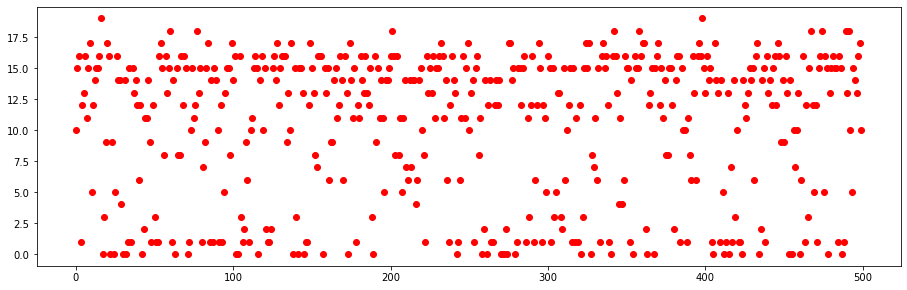

In [37]:
import csv
import matplotlib.pyplot as plt
import numpy as np
x1 = []
y1 = []
data1 = []
data = []

with open('Test3-sc.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    for row in plots:
        data1.append(row)
    for i in range(len(data1[0])):
        y1.append(int(data1[0][i]))
        x1.append(i)
print(len(y1)) 

data.append(len(y1)-np.count_nonzero(y1))
for i in range(1,max(y1)):

    data.append(np.count_nonzero(np.array(y1)==i))
    #print(np.count_nonzero(np.array(y1)==i))


with open(f'data.csv', 'w', encoding='UTF8') as f:
                            # create the csv writer
                writer = csv.writer(f)

                            # write a row to the csv file
                writer.writerow(data)



print(sum(y1)/len(y1))
print(max(y1))
print(np.std(y1))
print(np.var(y1))
plt.axes([0, 1, 2, 0.9])
plt.plot(x1,y1,'ro')

#plt.ylim(-12,-4

19


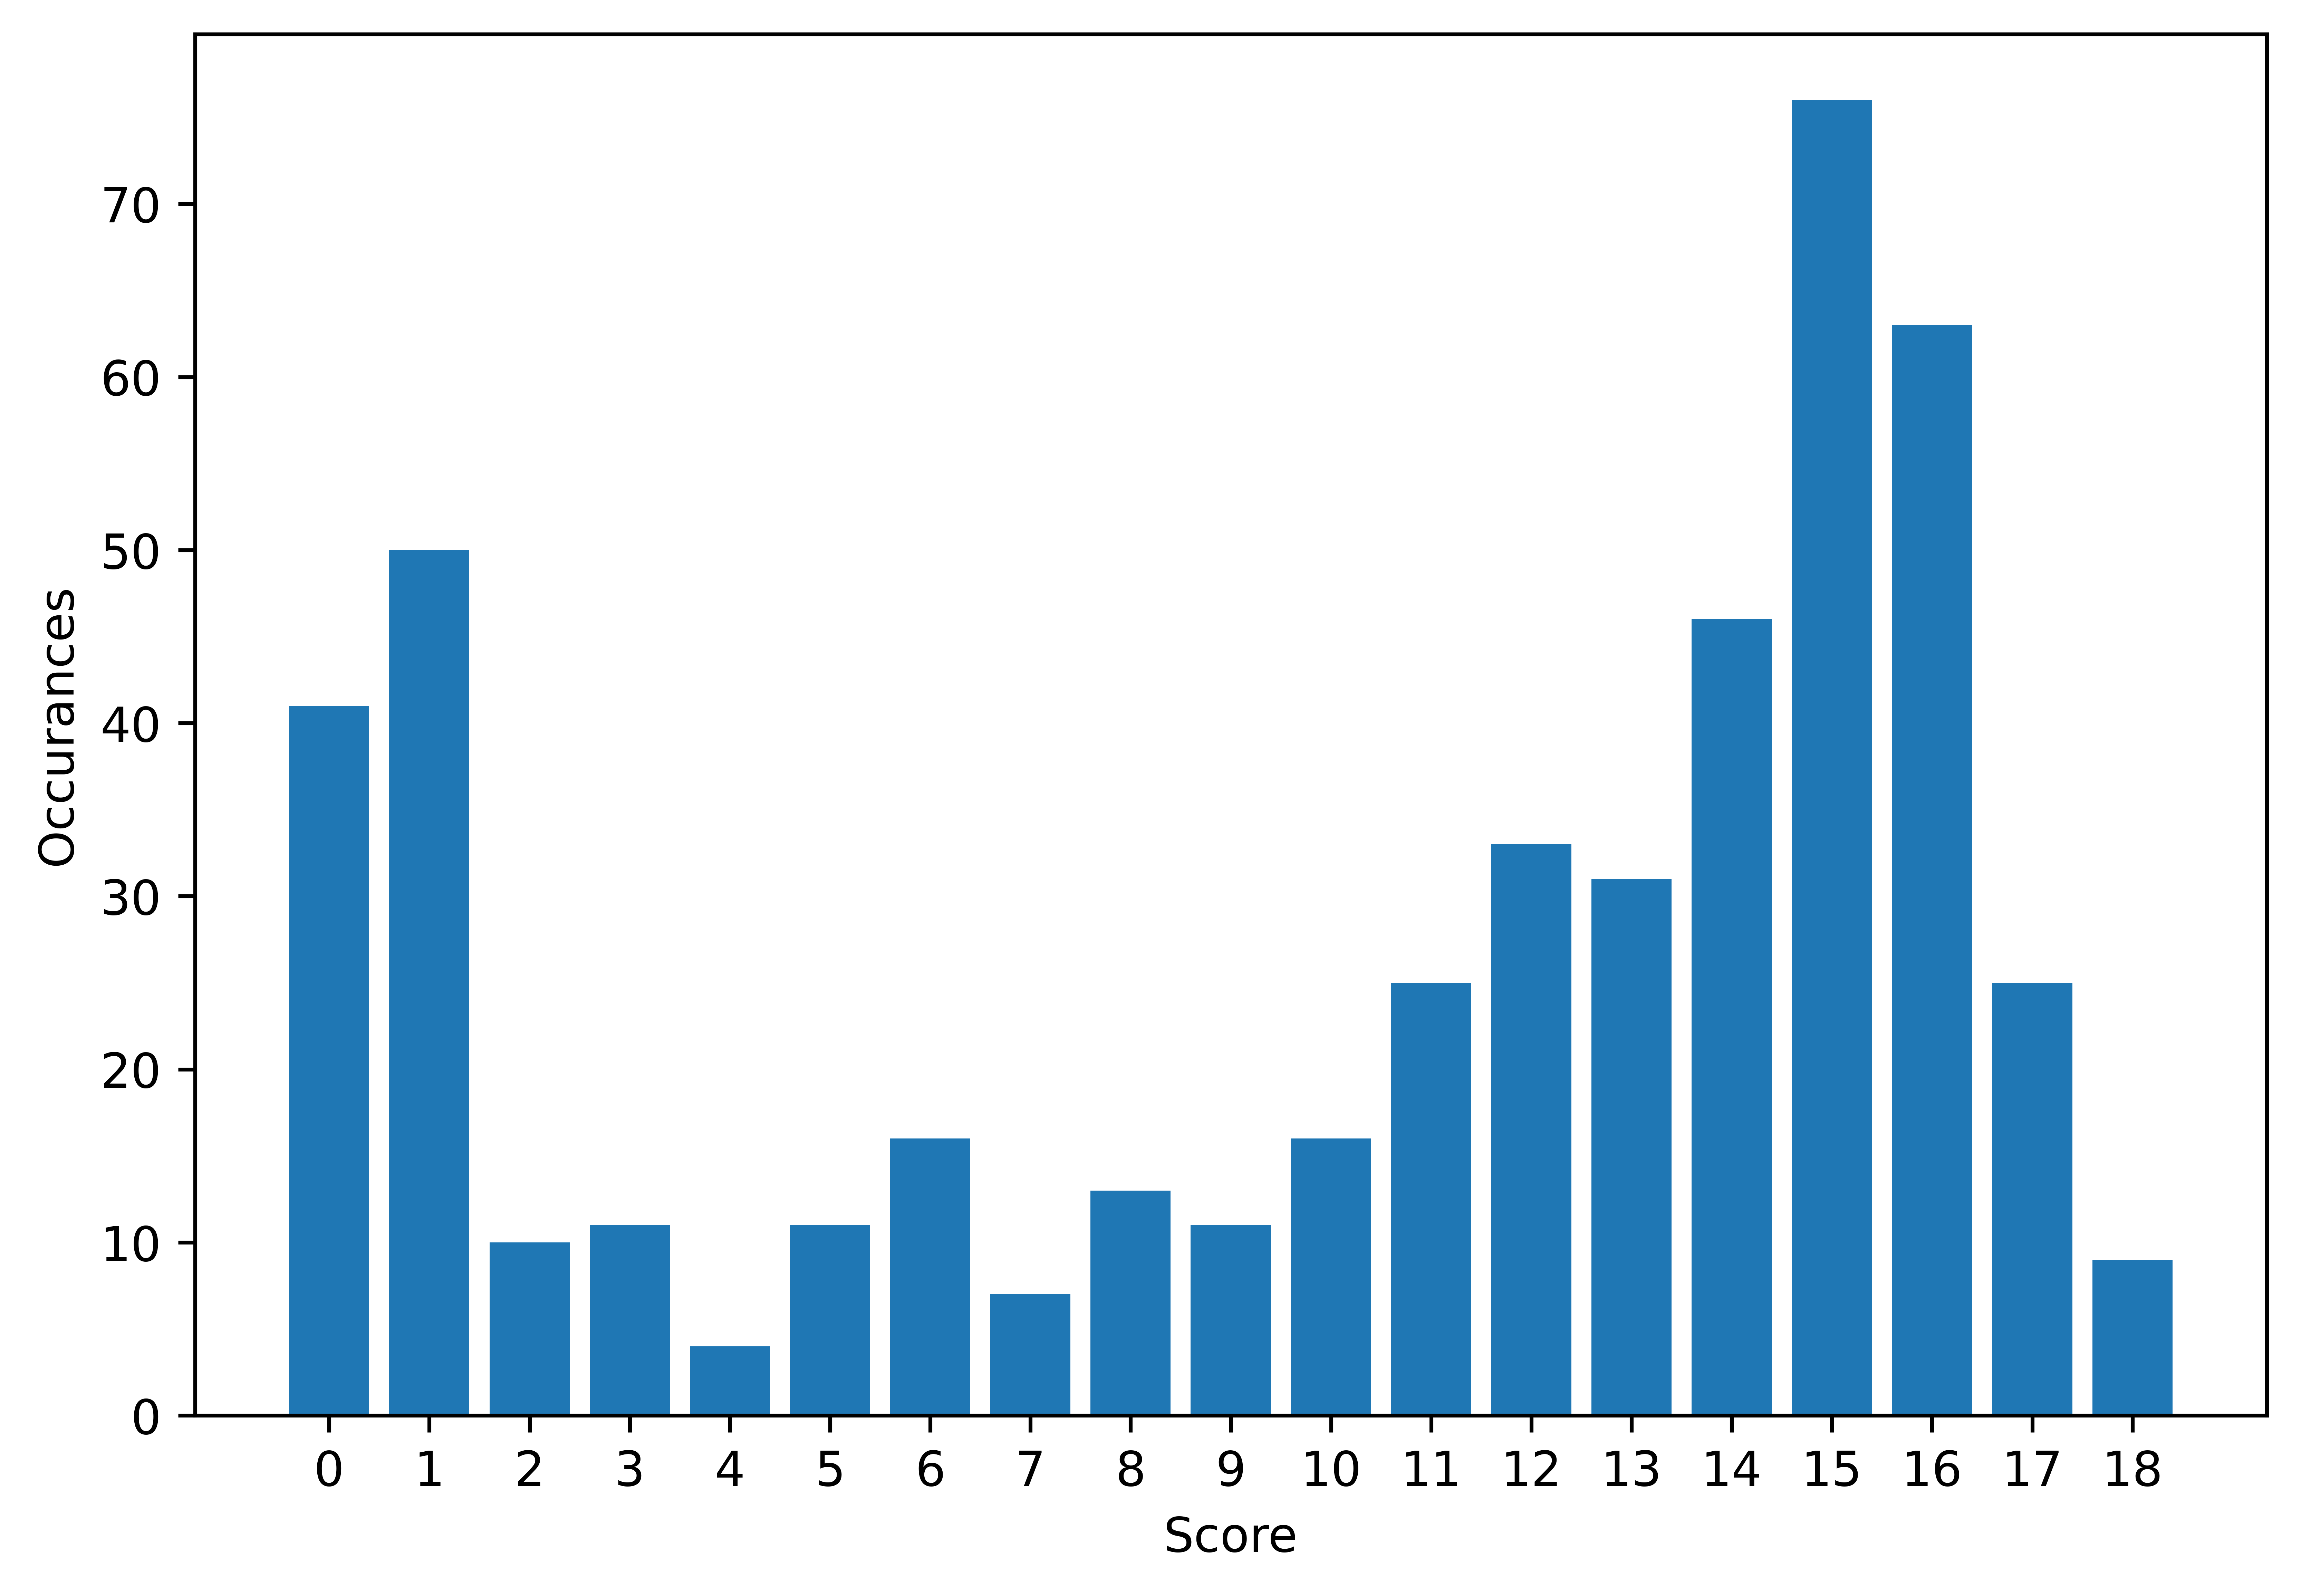

In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import statistics
x1 = []
y1 = []
data1 = []
data = []

with open('data.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    for row in plots:
        data1.append(row)
    for i in range(len(data1[0])):
        y1.append(int(data1[0][i]))
        x1.append(i)
print(len(y1)) 

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x1,y1)
#plt.axes([0, 1, 2, 0.9])
plt.rcParams['figure.dpi'] = 1000
plt.rcParams['savefig.dpi'] = 1000
#plt.title('Agent Testing results')
plt.xlabel('Score')
plt.xticks(np.arange(min(x1), max(x1)+1, 1.0))
plt.ylabel('Occurances')
plt.show()